Developing a simple model with the low-level
TensorFlow API

Now that we have familiarized ourselves with TensorFlow, let's take a look at a
really practical example and implement Ordinary Least Squares (OLS) regression.
For a quick refresher on regression analysis

In [ ]:
!pip install tensorflow
!pip install tensorflow-gpu

     |████████████████████████████████| 489.6 MB 13 kB/s 


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


Creating a small one-dimensional toy dataset with 10 training samples

In [ ]:
import numpy as np
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                    2.0, 5.0, 6.3,
                    6.6, 7.4, 8.0,
                    9.0])

Given this dataset, we want to train a linear regression model to predict the output y from the input x. Let's implement this model in a class, which we name TfLinreg. For this, we would need two placeholders—one for the input x and one for y for feeding the data into our model. Next, we need to define the trainable variables— weights w and bias b.

Then, we can define the linear regression model as z = w*x + b , followed by defining the cost function to be the Mean of Squared Error (MSE). To learn the weight parameters of the model, we use the gradient descent optimizer

In [ ]:
class TfLinreg(object):
  #This is the constructor method
  #Self is the instance
  def __init__(self, x_dim, learning_rate=0.01, random_seed=None):
    self.x_dim = x_dim
    self.learning_rate = learning_rate
    self.g = tf.Graph()

    ## build the model
    with self.g.as_default():
      ## set graph-level random-seed
      tf.set_random_seed(random_seed)
      self.build()
      ## create initializer
      self.init_op = tf.global_variables_initializer()

  def build(self):
    ## define placeholders for inputs
    self.X = tf.placeholder(dtype=tf.float32, shape=(None, self.x_dim), name='x_input')
    self.y = tf.placeholder(dtype=tf.float32, shape=(None), name='y_input')

    print(self.X)
    print(self.y)

    ## define weight matrix and bias vector
    w = tf.Variable(tf.zeros(shape=(1)),name='weight')
    b = tf.Variable(tf.zeros(shape=(1)),name="bias")
    print(w)
    print(b)

    self.z_net = tf.squeeze(w*self.X + b, name='z_net')
    print(self.z_net)
    sqr_errors = tf.square(self.y - self.z_net, name='sqr_errors')
    print(sqr_errors)
    self.mean_cost = tf.reduce_mean(sqr_errors,name='mean_cost')

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate, name='GradientDescent')
    self.optimizer = optimizer.minimize(self.mean_cost)


we have defined a class to construct our model. We will create an instance of
this class and call it lrmodel, as follows

In [ ]:
lrmodel = TfLinreg(x_dim=X_train.shape[1], learning_rate=0.01)


Tensor("x_input:0", shape=(?, 1), dtype=float32)
Tensor("y_input:0", dtype=float32)
<tf.Variable 'weight:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'bias:0' shape=(1,) dtype=float32_ref>
Tensor("z_net:0", dtype=float32)
Tensor("sqr_errors:0", dtype=float32)


The print statements that we wrote in the build method will display information
about six nodes in the graph—X, y, w, b, z_net, and sqr_errors—with their names
and shapes.

The next step is to implement a training function to learn the weights of the linear regression model. Note that b is the bias unit (the y-axis intercept at x = 0).

For training, we implement a separate function that needs a TensorFlow session, a model instance, training data, and the number of epochs as input arguments. In this function, first we initialize the variables in the TensorFlow session using the init_op operation defined in the model. Then, we iterate and call the optimizer operation of the model while feeding the training data. This function will return a list of training costs as a side product:

In [ ]:
def train_linreg(sess, model, X_train, y_train, num_epochs=10):
  print("X_train", X_train)
  print("y_train", y_train)
  ## initialiaze all variables: W and b
  sess.run(model.init_op)
  training_costs = []
  for i in range(num_epochs):
    _, cost = sess.run([model.optimizer, model.mean_cost],
    feed_dict={model.X:X_train,model.y:y_train})
    training_costs.append(cost)
  return training_costs

So, now we can create a new TensorFlow session to launch the lrmodel.g graph and
pass all the required arguments to the train_linreg function for training:

In [ ]:
sess = tf.Session(graph=lrmodel.g)
training_costs = train_linreg(sess, lrmodel, X_train, y_train)

X_train [[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]
y_train [1.  1.3 3.1 2.  5.  6.3 6.6 7.4 8.  9. ]


Let's visualize the training costs after these 10 epochs to see whether the model is converged or not:

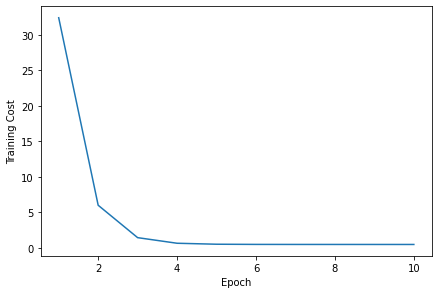

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(training_costs) + 1), training_costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Training Cost')
plt.show()

This simple model converges very quickly after a
few epochs

Looking at the cost function, it seems that we built a working regression model from this particular dataset. Now, let's compile a new function to make predictions based on the input features. For this function, we need the
TensorFlow session, the model, and the test dataset

In [ ]:
def predict_linreg(sess, model, X_test):
  y_pred = sess.run(model.z_net,feed_dict={model.X:X_test})
  return y_pred

Implementing a predict function was pretty straightforward; just running z_net
defined in the graph computes the predicted output values

let's plot the linear regression fit on the training data

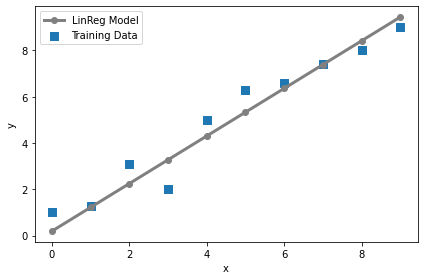

In [ ]:
plt.scatter(X_train, y_train,marker='s', s=50,label='Training Data')
plt.plot(range(X_train.shape[0]), 
         predict_linreg(sess, lrmodel, X_train),
         color='gray', marker='o',
         markersize=6, linewidth=3,
         label='LinReg Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()

Our model fits the training data points appropriately